In [9]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [10]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [11]:
# Random seed
#np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [12]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [13]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [14]:
df

x         y            z
0  2.678123 -1.114543   -39.868271
1  3.229399  1.467435  -136.945332
2  2.206671  3.058789 -4505.759032
3 -0.627355  0.759304   -18.043217
4  1.204635 -3.110546 -1386.571330

In [15]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [16]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.784944   -2.95814034]


In [17]:
df_sim = df.copy()

df_sim

x         y            z         a        b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.784944 -2.95814   -40.038716  0.170446
1  3.229399  1.467435  -136.945332  3.784944 -2.95814  -136.848457 -0.096875
2  2.206671  3.058789 -4505.759032  3.784944 -2.95814 -4505.412475 -0.346557
3 -0.627355  0.759304   -18.043217  3.784944 -2.95814   -17.901847 -0.141370
4  1.204635 -3.110546 -1386.571330  3.784944 -2.95814 -1386.607057  0.035727

In [18]:
df

x         y            z         a        b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.784944 -2.95814   -40.038716  0.170446
1  3.229399  1.467435  -136.945332  3.784944 -2.95814  -136.848457 -0.096875
2  2.206671  3.058789 -4505.759032  3.784944 -2.95814 -4505.412475 -0.346557
3 -0.627355  0.759304   -18.043217  3.784944 -2.95814   -17.901847 -0.141370
4  1.204635 -3.110546 -1386.571330  3.784944 -2.95814 -1386.607057  0.035727

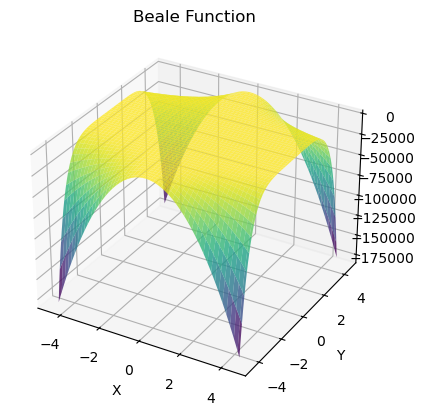

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Beale Function')

# Show the plot
plt.show()

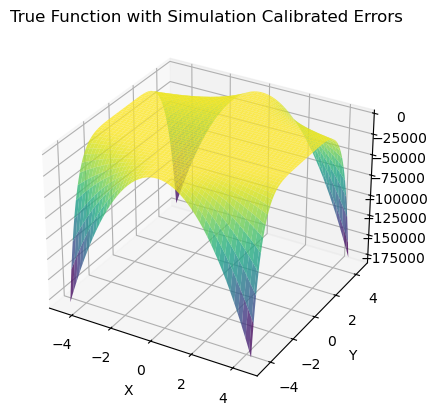

In [20]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [21]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [22]:
df_new = pd.DataFrame

In [23]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-4.5, 4.5, 100)
    x2_range = np.linspace(-4.5, 4.5, 100)
    bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    return df, df2


Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.0001521519381262153
dropout_rate: 0.0
batch_size: 20
epochs: 96
Epoch 1/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4448434.0000
Epoch 2/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4448426.0000
Epoch 3/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4448416.0000
Epoch 4/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4448408.5000
Epoch 5/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448399.5000
Epoch 6/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4448391.5000
Epoch 7/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448384.5000
Epoch 8/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448377.5000
Epoch 9/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448371.5000
Epoch 10/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4448366.0000
Epoch 11/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448359.5000
Epoch 12/96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4448353.5000
Epoch 13/96
1/1 ━━━━━━━━━━━

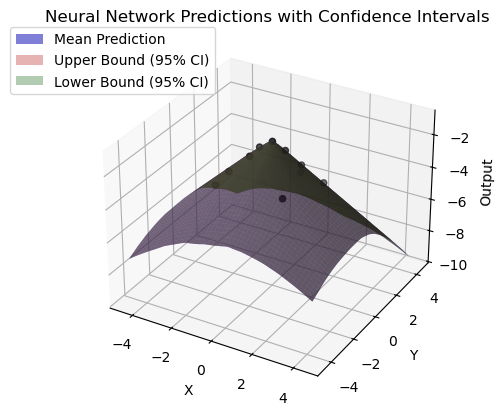

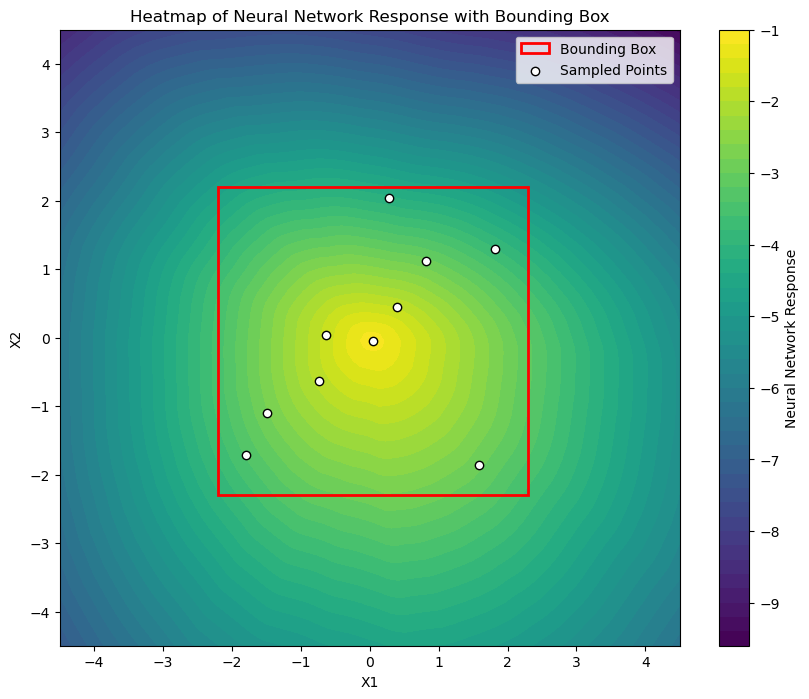

          x         y          z         a        b      sim_z      diff
2  0.397858  0.452861 -10.615881  3.784944 -2.95814 -10.506303 -0.109578
9  0.045455 -0.045455 -13.674230  3.784944 -2.95814 -13.618990 -0.055240
8  0.817439  1.124541 -17.458372  3.784944 -2.95814 -17.450569 -0.007803
4 -0.634055  0.033046 -23.412257  3.784944 -2.95814 -23.381057 -0.031200
0 -0.736905 -0.631034 -27.177102  3.784944 -2.95814 -27.100029 -0.077072
           x         y            z         a        b        sim_z      diff
0   2.678123 -1.114543   -39.868271  3.784944 -2.95814   -40.038716  0.170446
1   3.229399  1.467435  -136.945332  3.784944 -2.95814  -136.848457 -0.096875
2   2.206671  3.058789 -4505.759032  3.784944 -2.95814 -4505.412475 -0.346557
3  -0.627355  0.759304   -18.043217  3.784944 -2.95814   -17.901847 -0.141370
4   1.204635 -3.110546 -1386.571330  3.784944 -2.95814 -1386.607057  0.035727
5  -0.736905 -0.631034   -27.177102  3.784944 -2.95814   -27.100029 -0.077072
6  -1.495073 -1.

In [24]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 8
num_units: 50
learning_rate: 0.0030303034798874677
dropout_rate: 0.16785727428998726
batch_size: 82
epochs: 198
Epoch 1/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1487957.5000
Epoch 2/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1487943.8750
Epoch 3/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1487883.8750
Epoch 4/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1487883.6250
Epoch 5/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1487883.3750
Epoch 6/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1487806.0000
Epoch 7/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1487818.2500
Epoch 8/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1487721.3750
Epoch 9/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1487716.5000
Epoch 10/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1487573.8750
Epoch 11/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1487438.0000
Epoch 12/198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1487183.1250

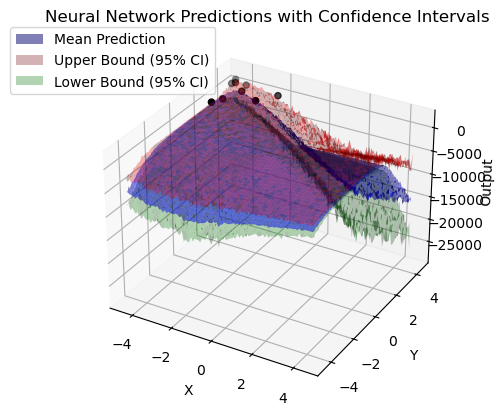

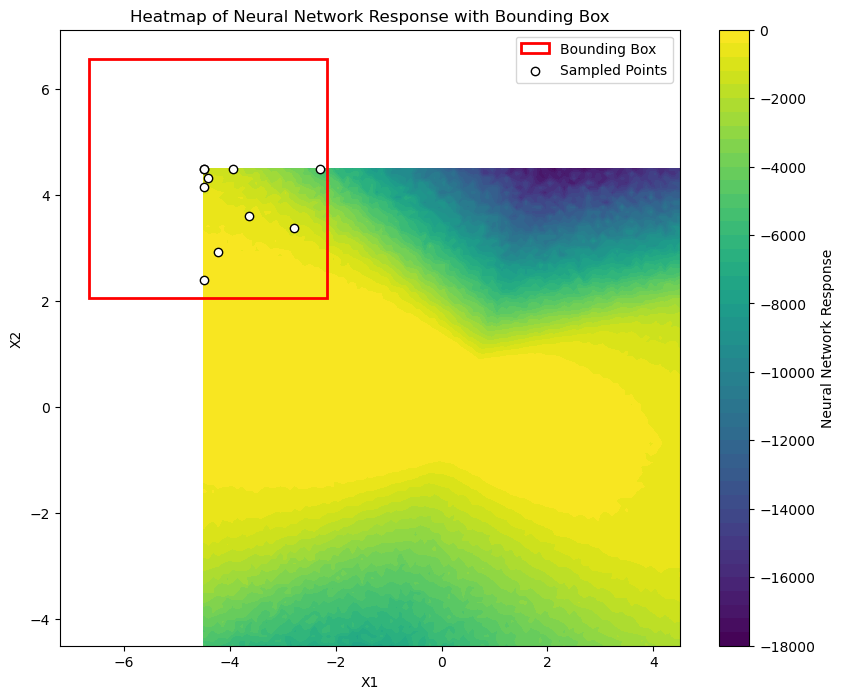

In [25]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0010208090293374107
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4185298944.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4185296128.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4185290752.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4185282560.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4185266688.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4185237760.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4185187584.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4185103360.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4184961792.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4184729856.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4184351744.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 

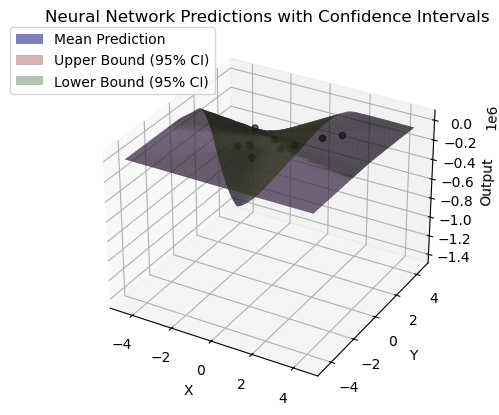

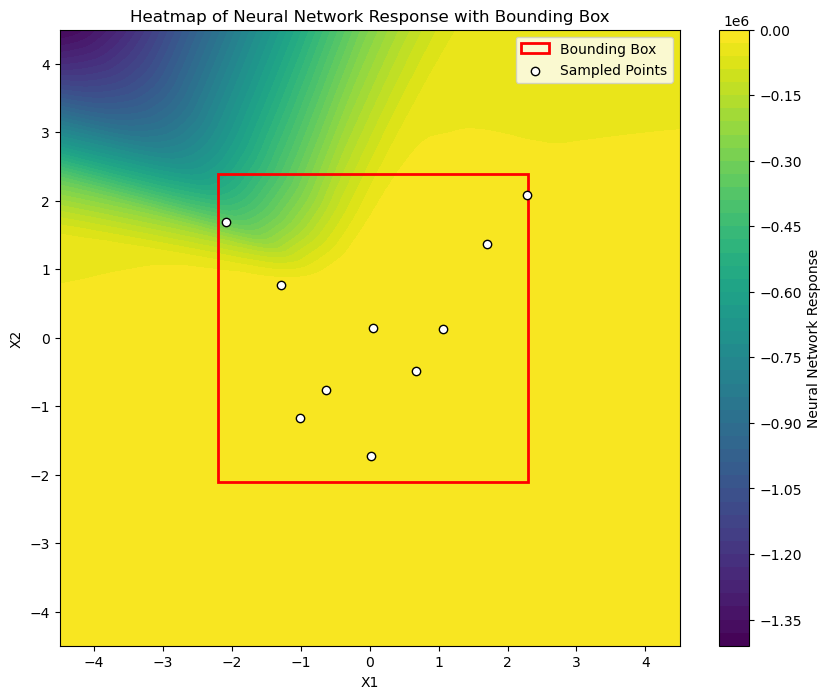

In [26]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 200
learning_rate: 0.018276528356053687
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2989514240.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2989267712.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2988496896.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2986117632.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2982021120.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2973626624.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2960778240.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2945205760.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2905982464.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2888309760.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2842168064.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - 

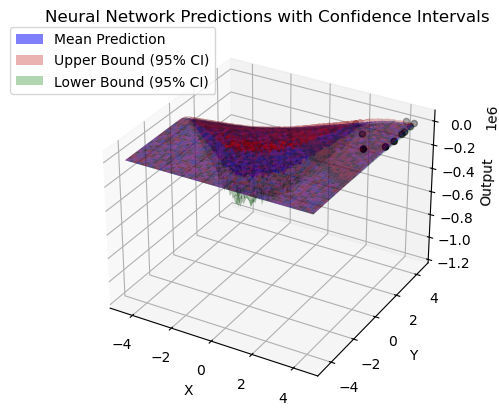

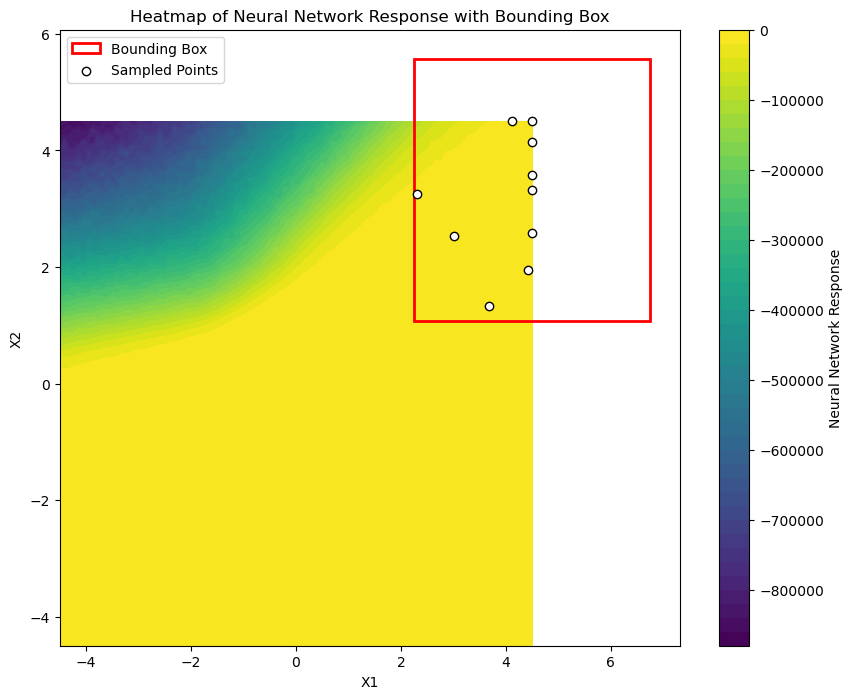

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 194
learning_rate: 0.028802070180505
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3985980160.0000
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3735098624.0000 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3410377216.0000 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2507927552.0000 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2174618624.0000 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1934209536.0000 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1652740352.0000 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1866965760.0000 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1370681344.0000 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1180174592.0000
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1033254720.0000
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

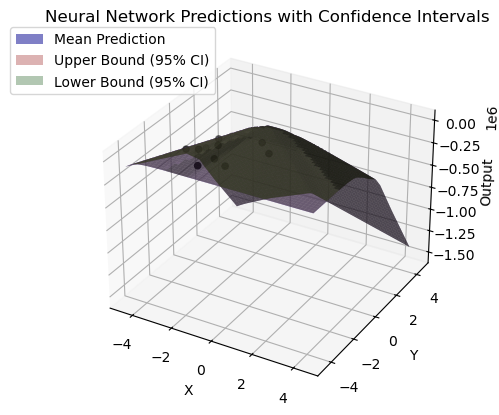

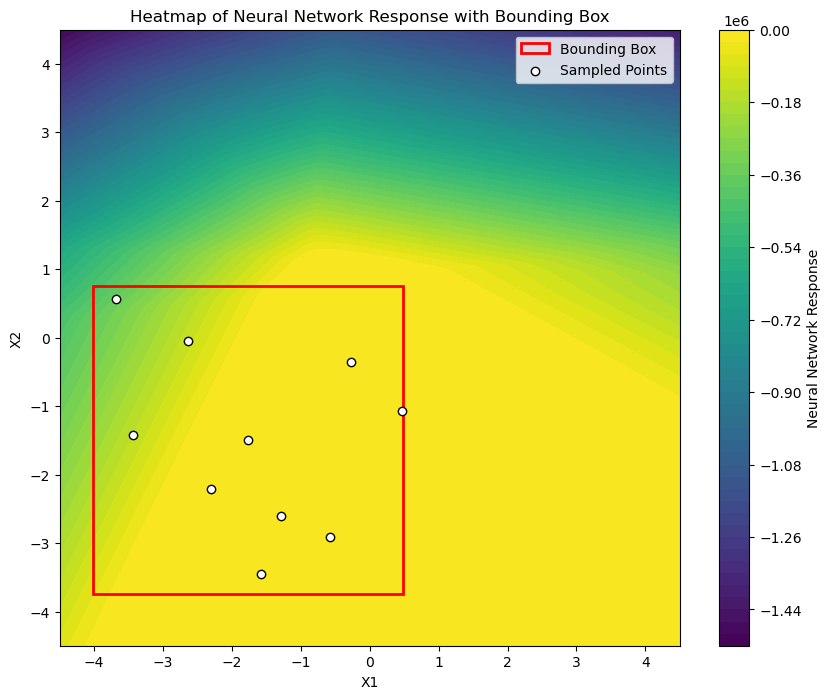

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.0029970591015138844
dropout_rate: 0.008261323089814953
batch_size: 20
epochs: 146
Epoch 1/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3266309376.0000
Epoch 2/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2786341376.0000 
Epoch 3/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2784243712.0000 
Epoch 4/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3511580928.0000 
Epoch 5/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3361263616.0000 
Epoch 6/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3812299264.0000 
Epoch 7/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2605431552.0000 
Epoch 8/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3114070016.0000 
Epoch 9/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2382110464.0000 
Epoch 10/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3246458368.0000 
Epoch 11/146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3432409088.0000 
Epoch 12/146
3/3 ━━━━━━━━━━━━━━━━━━

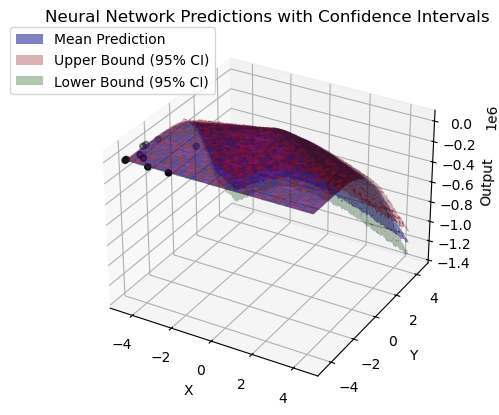

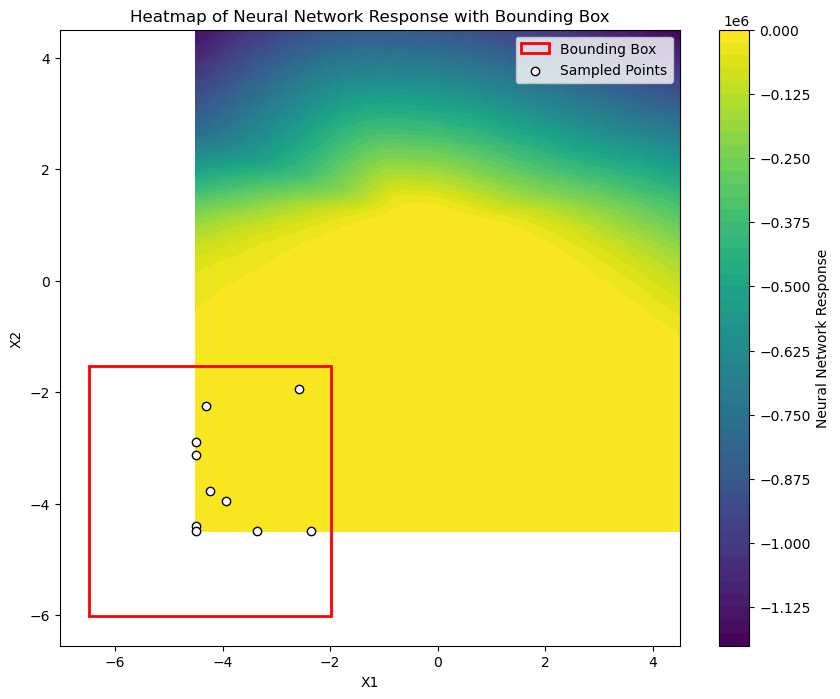

          x         y             z         a        b         sim_z      diff
5 -2.586536 -1.941135   -689.268754  3.784944 -2.95814   -689.102656 -0.166098
0 -4.314284 -2.243665  -3568.653542  3.784944 -2.95814  -3568.222507 -0.431035
6 -4.500000 -2.903537 -15090.218282  3.784944 -2.95814 -15089.699397 -0.518885
4 -4.500000 -3.132908 -22973.969459  3.784944 -2.95814 -22973.556186 -0.413273
8 -2.348249 -4.500000 -49995.176272  3.784944 -2.95814 -49994.811130 -0.365142
           x         y              z         a        b          sim_z  \
0   2.678123 -1.114543     -39.868271  3.784944 -2.95814     -40.038716   
1   3.229399  1.467435    -136.945332  3.784944 -2.95814    -136.848457   
2   2.206671  3.058789   -4505.759032  3.784944 -2.95814   -4505.412475   
3  -0.627355  0.759304     -18.043217  3.784944 -2.95814     -17.901847   
4   1.204635 -3.110546   -1386.571330  3.784944 -2.95814   -1386.607057   
..       ...       ...            ...       ...      ...            ...   
6

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 9
num_units: 200
learning_rate: 0.0007718546927315734
dropout_rate: 0.0
batch_size: 150
epochs: 173
Epoch 1/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3864853504.0000
Epoch 2/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3864849920.0000
Epoch 3/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3864846080.0000
Epoch 4/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3864837632.0000
Epoch 5/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3864825600.0000
Epoch 6/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3864806656.0000
Epoch 7/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3864777216.0000
Epoch 8/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3864732928.0000
Epoch 9/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3864667392.0000
Epoch 10/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3864570112.0000
Epoch 11/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3864429824.0000
Epoch 12/173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step -

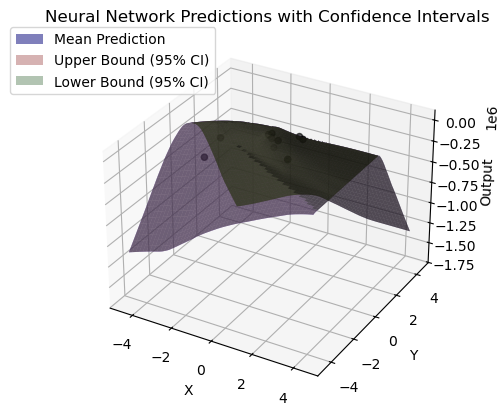

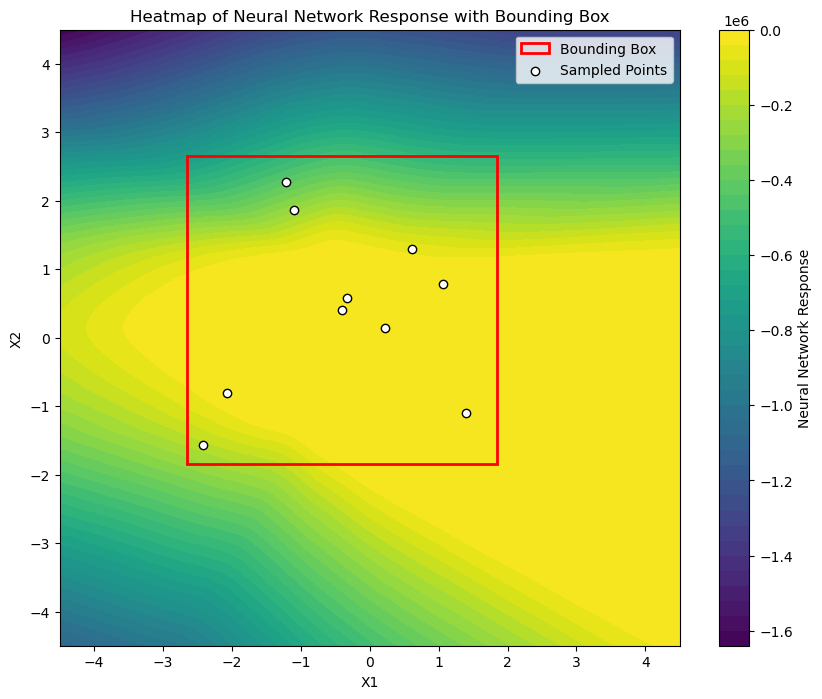

          x         y          z         a        b      sim_z      diff
3  1.389885 -1.097293  -8.806398  3.784944 -2.95814  -8.853804  0.047406
4  1.069501  0.780979  -9.083078  3.784944 -2.95814  -9.219895  0.136818
8  0.215422  0.143510 -11.664765  3.784944 -2.95814 -11.698770  0.034005
0 -1.093670  1.865777 -12.066610  3.784944 -2.95814 -12.005362 -0.061248
1 -0.337806  0.573122 -17.187386  3.784944 -2.95814 -17.239335  0.051949


In [30]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [31]:
df_new

x         y          z         a        b      sim_z      diff
3  1.389885 -1.097293  -8.806398  3.784944 -2.95814  -8.853804  0.047406
4  1.069501  0.780979  -9.083078  3.784944 -2.95814  -9.219895  0.136818
8  0.215422  0.143510 -11.664765  3.784944 -2.95814 -11.698770  0.034005
0 -1.093670  1.865777 -12.066610  3.784944 -2.95814 -12.005362 -0.061248
1 -0.337806  0.573122 -17.187386  3.784944 -2.95814 -17.239335  0.051949

In [32]:
df

x         y            z         a        b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.784944 -2.95814   -40.038716  0.170446
1  3.229399  1.467435  -136.945332  3.784944 -2.95814  -136.848457 -0.096875
2  2.206671  3.058789 -4505.759032  3.784944 -2.95814 -4505.412475 -0.346557
3 -0.627355  0.759304   -18.043217  3.784944 -2.95814   -17.901847 -0.141370
4  1.204635 -3.110546 -1386.571330  3.784944 -2.95814 -1386.607057  0.035727

In [33]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.07572571179986624


In [34]:
df = pd.concat([df, df_new], ignore_index=True)
df

x         y            z         a        b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.784944 -2.95814   -40.038716  0.170446
1  3.229399  1.467435  -136.945332  3.784944 -2.95814  -136.848457 -0.096875
2  2.206671  3.058789 -4505.759032  3.784944 -2.95814 -4505.412475 -0.346557
3 -0.627355  0.759304   -18.043217  3.784944 -2.95814   -17.901847 -0.141370
4  1.204635 -3.110546 -1386.571330  3.784944 -2.95814 -1386.607057  0.035727
5  1.389885 -1.097293    -8.806398  3.784944 -2.95814    -8.853804  0.047406
6  1.069501  0.780979    -9.083078  3.784944 -2.95814    -9.219895  0.136818
7  0.215422  0.143510   -11.664765  3.784944 -2.95814   -11.698770  0.034005
8 -1.093670  1.865777   -12.066610  3.784944 -2.95814   -12.005362 -0.061248
9 -0.337806  0.573122   -17.187386  3.784944 -2.95814   -17.239335  0.051949

In [35]:
df = df.iloc[:, :-4]
df

x         y            z
0  2.678123 -1.114543   -39.868271
1  3.229399  1.467435  -136.945332
2  2.206671  3.058789 -4505.759032
3 -0.627355  0.759304   -18.043217
4  1.204635 -3.110546 -1386.571330
5  1.389885 -1.097293    -8.806398
6  1.069501  0.780979    -9.083078
7  0.215422  0.143510   -11.664765
8 -1.093670  1.865777   -12.066610
9 -0.337806  0.573122   -17.187386

In [36]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 3.80799394 -2.97570833]


In [37]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X    Y    Z
0  3  0.5 -0.0

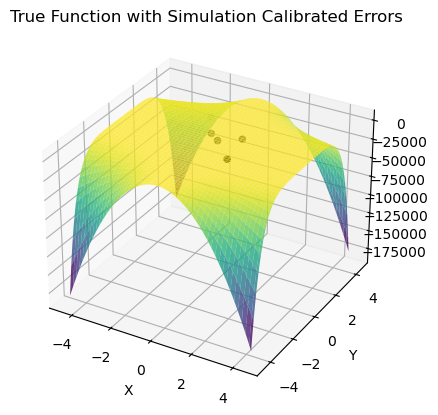

In [38]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [39]:
df

x         y            z         a         b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.807994 -2.975708   -39.979389  0.111119
1  3.229399  1.467435  -136.945332  3.807994 -2.975708  -136.797468 -0.147864
2  2.206671  3.058789 -4505.759032  3.807994 -2.975708 -4505.523142 -0.235890
3 -0.627355  0.759304   -18.043217  3.807994 -2.975708   -17.888080 -0.155137
4  1.204635 -3.110546 -1386.571330  3.807994 -2.975708 -1386.741914  0.170584
5  1.389885 -1.097293    -8.806398  3.807994 -2.975708    -8.817064  0.010665
6  1.069501  0.780979    -9.083078  3.807994 -2.975708    -9.184094  0.101016
7  0.215422  0.143510   -11.664765  3.807994 -2.975708   -11.665568  0.000803
8 -1.093670  1.865777   -12.066610  3.807994 -2.975708   -11.976571 -0.090039
9 -0.337806  0.573122   -17.187386  3.807994 -2.975708   -17.207885  0.020499

In [40]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.021424255942015157


In [41]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y            z         a         b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.807994 -2.975708   -39.979389  0.111119
1  3.229399  1.467435  -136.945332  3.807994 -2.975708  -136.797468 -0.147864
2  2.206671  3.058789 -4505.759032  3.807994 -2.975708 -4505.523142 -0.235890
3 -0.627355  0.759304   -18.043217  3.807994 -2.975708   -17.888080 -0.155137
4  1.204635 -3.110546 -1386.571330  3.807994 -2.975708 -1386.741914  0.170584


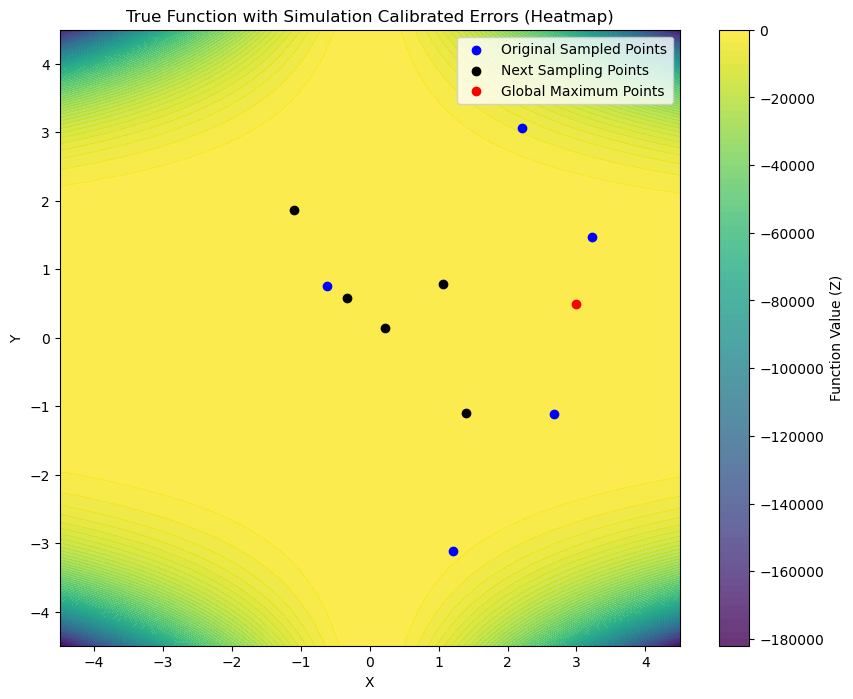

In [42]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [43]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 10
num_units: 179
learning_rate: 0.02556451860139431
dropout_rate: 0.4883201411964195
batch_size: 124
epochs: 98
Epoch 1/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2224296.5000
Epoch 2/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2145021.5000
Epoch 3/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1853349.3750
Epoch 4/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1809841.6250
Epoch 5/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 387976.2188
Epoch 6/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6639404.0000
Epoch 7/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1815352.0000
Epoch 8/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2216991.0000
Epoch 9/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1796971.6250
Epoch 10/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1735006.7500
Epoch 11/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 768317.3750
Epoch 12/98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 34984820.0000
Epoch 13/98
1

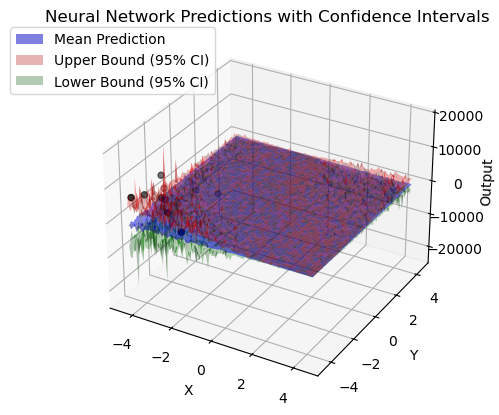

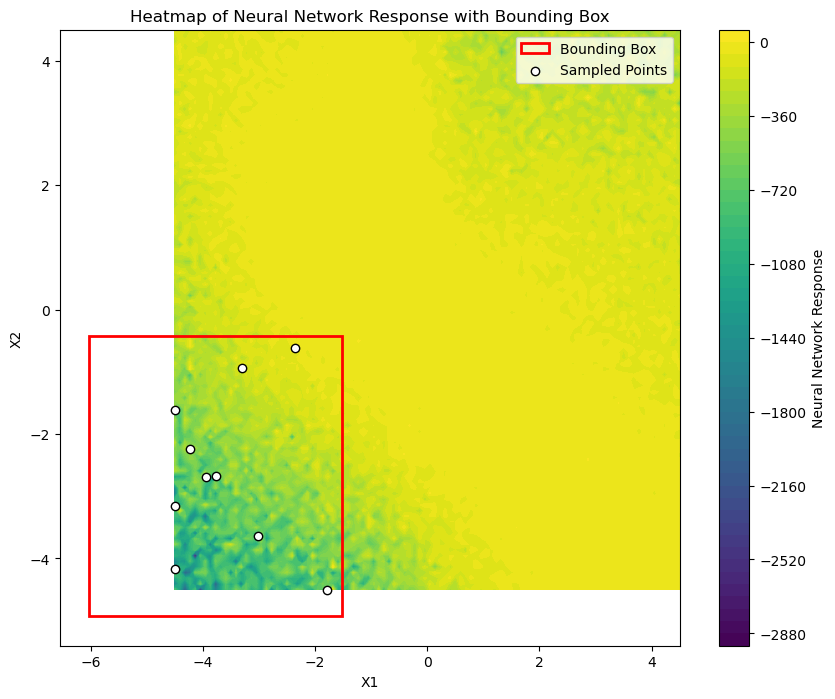

In [44]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.002043535566357031
dropout_rate: 0.0
batch_size: 38
epochs: 172
Epoch 1/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 781854656.0000
Epoch 2/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 781849792.0000
Epoch 3/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 781837056.0000
Epoch 4/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 781808000.0000
Epoch 5/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 781747200.0000
Epoch 6/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 781623552.0000
Epoch 7/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 781381504.0000
Epoch 8/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 780922944.0000
Epoch 9/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 780077184.0000
Epoch 10/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 778566016.0000
Epoch 11/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 775926400.0000
Epoch 12/172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 771444

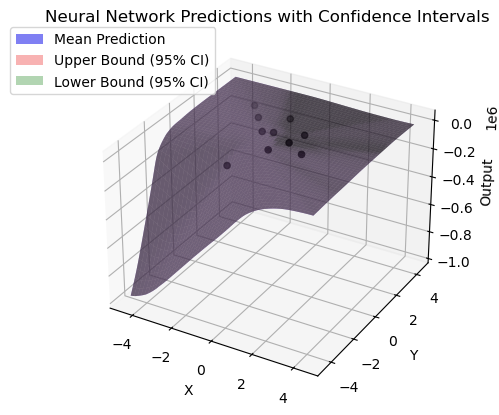

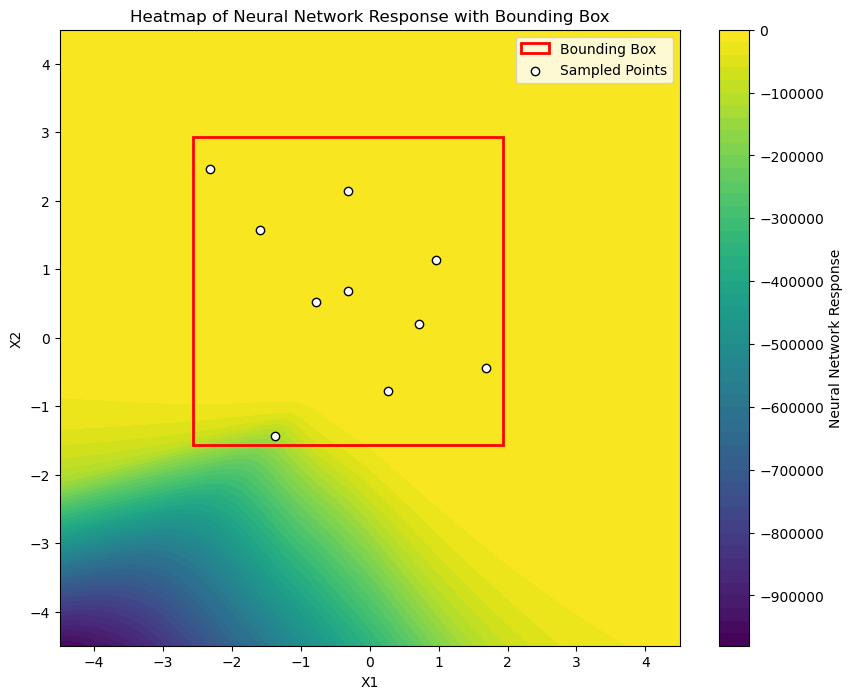

In [45]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 102
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 606320640.0000
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 370598240.0000 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 316047744.0000
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 200899712.0000
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273929856.0000 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 466605408.0000 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 279989632.0000 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 243617520.0000
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 383678784.0000 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 408936160.0000 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 237675744.0000
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 371625600.0000 
Epoch 13/20

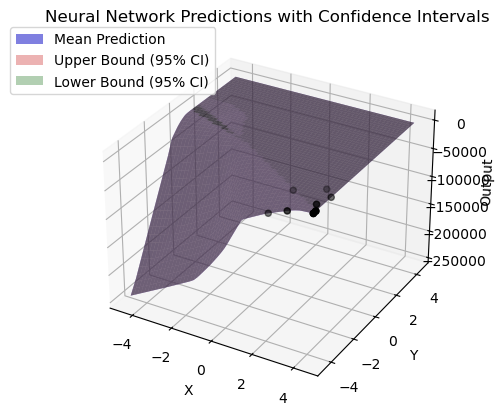

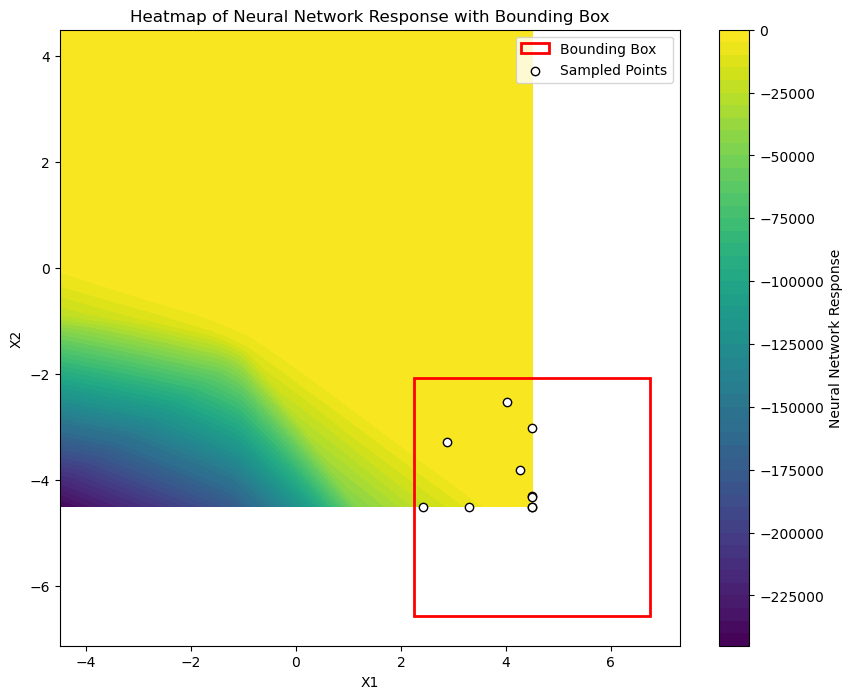

In [46]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0019247732684842867
dropout_rate: 0.09108756032149917
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3642374912.0000
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3795425280.0000 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3504691968.0000 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2818712832.0000 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3826496256.0000 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3261916928.0000 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2870961920.0000 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2316068352.0000 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1289194752.0000
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1512228224.0000 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1072285760.0000 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━

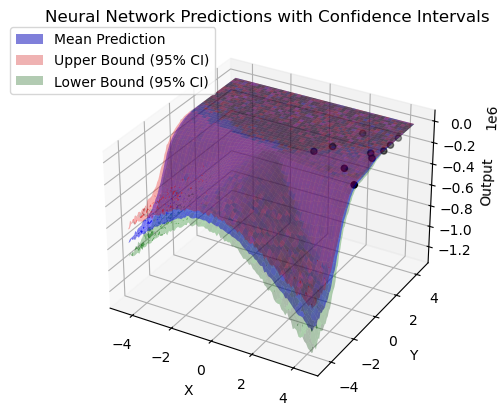

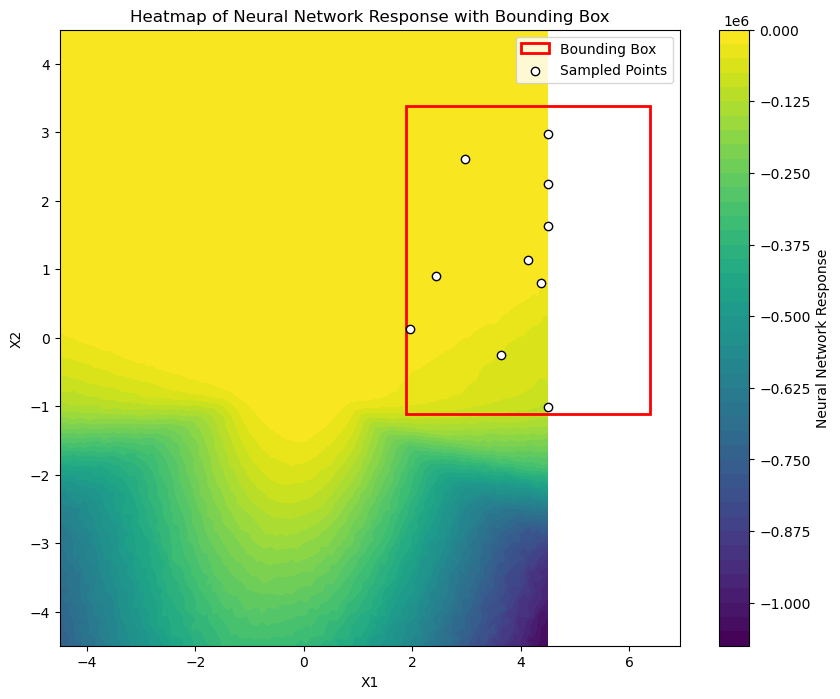

In [47]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 200
learning_rate: 0.029821132573792705
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2656353792.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2655467008.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2651879680.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2642359808.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2621988096.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2583880960.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2518747392.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2415321856.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2261735936.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2048280832.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1774528256.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - 

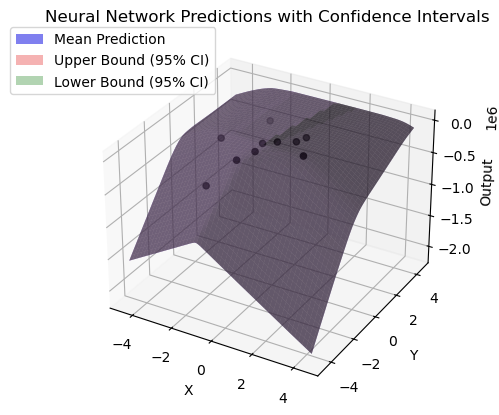

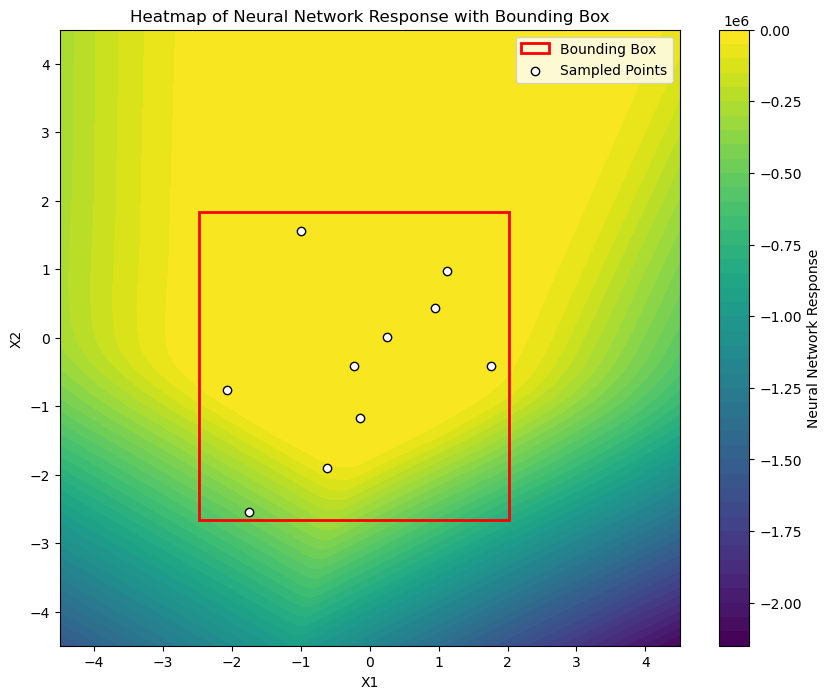

In [48]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 200
learning_rate: 0.031849459162419366
dropout_rate: 0.0
batch_size: 150
epochs: 176
Epoch 1/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2213659136.0000
Epoch 2/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2213058560.0000
Epoch 3/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2210274816.0000
Epoch 4/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2202588160.0000
Epoch 5/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2185788672.0000
Epoch 6/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2153937664.0000
Epoch 7/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2099145088.0000
Epoch 8/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2011729024.0000
Epoch 9/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1880580224.0000
Epoch 10/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1698306688.0000
Epoch 11/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1467674240.0000
Epoch 12/176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - 

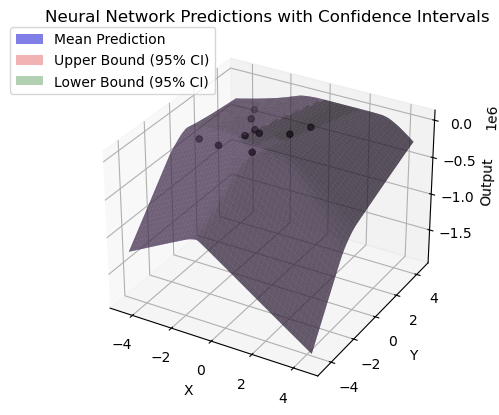

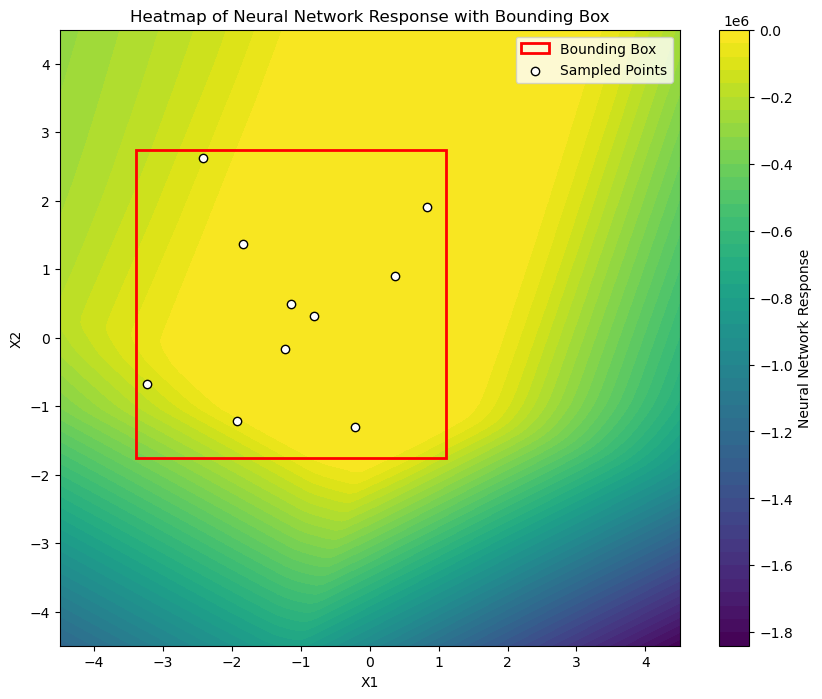

In [49]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 50
learning_rate: 0.009187234240098645
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1897455872.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1897432704.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1897383936.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1897284096.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1897095168.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1896744704.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1896112640.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1895017216.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1893175680.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1890161920.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1885342208.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - l

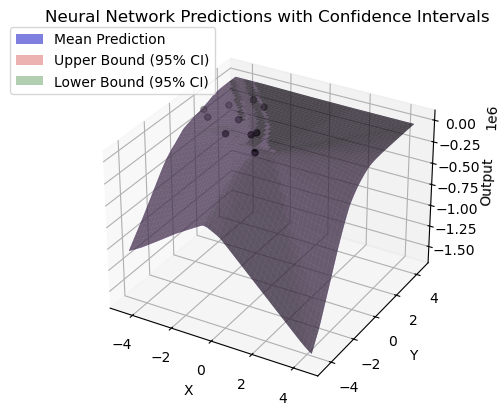

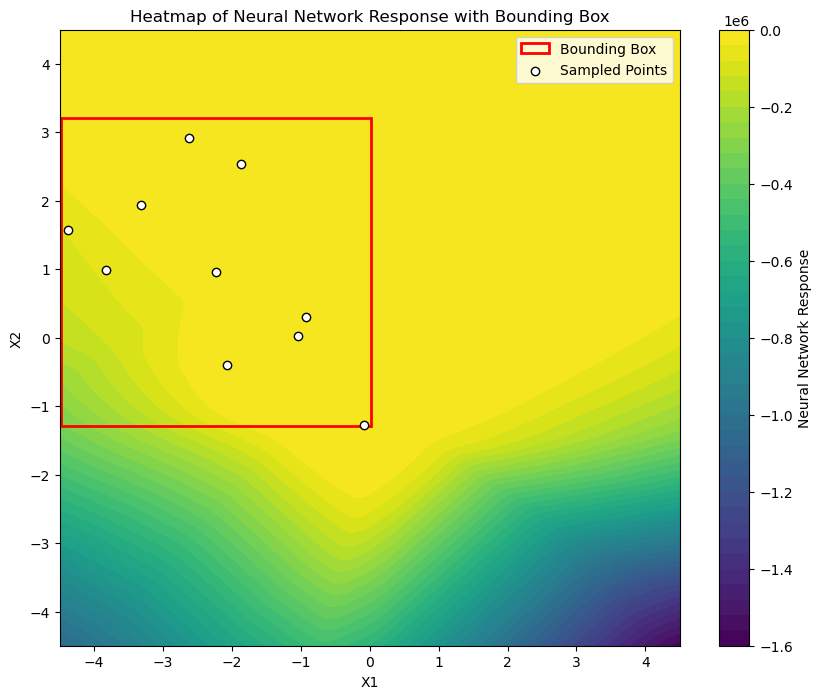

In [50]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [51]:
df_new2

x         y          z         a         b      sim_z      diff
5 -3.828957  0.994052 -14.880965  3.807994 -2.975708 -14.848613 -0.032352
6 -0.090389 -1.282178 -16.128330  3.807994 -2.975708 -16.122089 -0.006241
9 -2.227273  0.954545 -17.114987  3.807994 -2.975708 -17.043522 -0.071466
2 -0.929434  0.299510 -26.655697  3.807994 -2.975708 -26.629731 -0.025966
4 -1.047704  0.027227 -30.685369  3.807994 -2.975708 -30.654920 -0.030449

In [52]:
df

x         y            z         a         b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.807994 -2.975708   -39.979389  0.111119
1  3.229399  1.467435  -136.945332  3.807994 -2.975708  -136.797468 -0.147864
2  2.206671  3.058789 -4505.759032  3.807994 -2.975708 -4505.523142 -0.235890
3 -0.627355  0.759304   -18.043217  3.807994 -2.975708   -17.888080 -0.155137
4  1.204635 -3.110546 -1386.571330  3.807994 -2.975708 -1386.741914  0.170584
5  1.389885 -1.097293    -8.806398  3.807994 -2.975708    -8.817064  0.010665
6  1.069501  0.780979    -9.083078  3.807994 -2.975708    -9.184094  0.101016
7  0.215422  0.143510   -11.664765  3.807994 -2.975708   -11.665568  0.000803
8 -1.093670  1.865777   -12.066610  3.807994 -2.975708   -11.976571 -0.090039
9 -0.337806  0.573122   -17.187386  3.807994 -2.975708   -17.207885  0.020499

In [53]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x         y            z         a         b        sim_z      diff
0   2.678123 -1.114543   -39.868271  3.807994 -2.975708   -39.979389  0.111119
1   3.229399  1.467435  -136.945332  3.807994 -2.975708  -136.797468 -0.147864
2   2.206671  3.058789 -4505.759032  3.807994 -2.975708 -4505.523142 -0.235890
3  -0.627355  0.759304   -18.043217  3.807994 -2.975708   -17.888080 -0.155137
4   1.204635 -3.110546 -1386.571330  3.807994 -2.975708 -1386.741914  0.170584
5   1.389885 -1.097293    -8.806398  3.807994 -2.975708    -8.817064  0.010665
6   1.069501  0.780979    -9.083078  3.807994 -2.975708    -9.184094  0.101016
7   0.215422  0.143510   -11.664765  3.807994 -2.975708   -11.665568  0.000803
8  -1.093670  1.865777   -12.066610  3.807994 -2.975708   -11.976571 -0.090039
9  -0.337806  0.573122   -17.187386  3.807994 -2.975708   -17.207885  0.020499
10 -3.828957  0.994052   -14.880965  3.807994 -2.975708   -14.848613 -0.032352
11 -0.090389 -1.282178   -16.128330  3.807994 -2.975708   -16.122089 -0.006241
12 -2.227273  0.954545   -17.114987  3.807994 -2.975708   -17.043522 -0.071466
13 -0.929434  0.299510   -26.655697  3.807994 -2.975708   -26.629731 -0.025966
14 -1.047704  0.027227   -30.685369  3.807994 -2.975708   -30.654920 -0.030449

In [54]:
df = df.iloc[:, :-4]
df

x         y            z
0   2.678123 -1.114543   -39.868271
1   3.229399  1.467435  -136.945332
2   2.206671  3.058789 -4505.759032
3  -0.627355  0.759304   -18.043217
4   1.204635 -3.110546 -1386.571330
5   1.389885 -1.097293    -8.806398
6   1.069501  0.780979    -9.083078
7   0.215422  0.143510   -11.664765
8  -1.093670  1.865777   -12.066610
9  -0.337806  0.573122   -17.187386
10 -3.828957  0.994052   -14.880965
11 -0.090389 -1.282178   -16.128330
12 -2.227273  0.954545   -17.114987
13 -0.929434  0.299510   -26.655697
14 -1.047704  0.027227   -30.685369

In [55]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.90493719 -3.10400274]


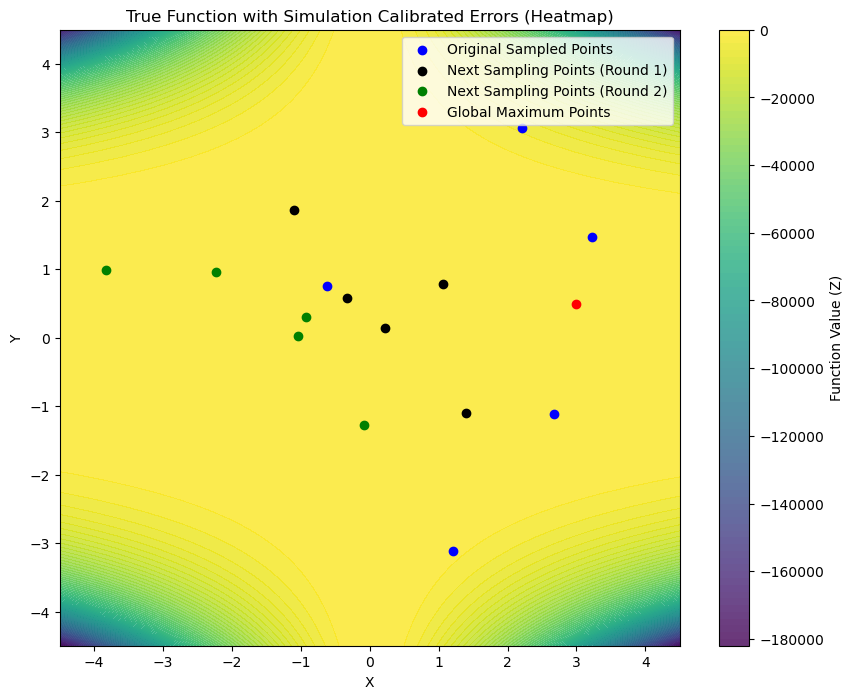

In [56]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [57]:
df_original

x         y            z         a         b        sim_z      diff
0  2.678123 -1.114543   -39.868271  3.807994 -2.975708   -39.979389  0.111119
1  3.229399  1.467435  -136.945332  3.807994 -2.975708  -136.797468 -0.147864
2  2.206671  3.058789 -4505.759032  3.807994 -2.975708 -4505.523142 -0.235890
3 -0.627355  0.759304   -18.043217  3.807994 -2.975708   -17.888080 -0.155137
4  1.204635 -3.110546 -1386.571330  3.807994 -2.975708 -1386.741914  0.170584

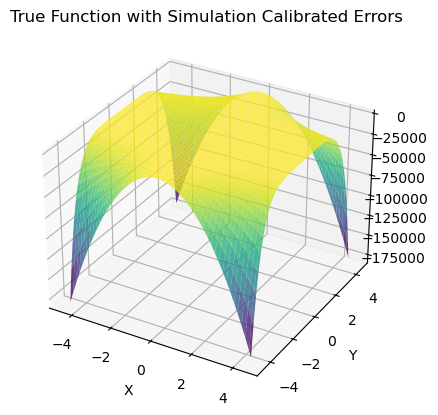

In [58]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [59]:
df_new3 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.0007973773539448816
dropout_rate: 0.0
batch_size: 45
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step - loss: 1483046.8750
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1483002.5000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1482958.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1482914.7500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1482871.2500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1482828.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1482784.1250
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1482739.8750
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1482693.6250
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1482646.6250
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1482598.8750
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1482550.6250
Epoch 13/200

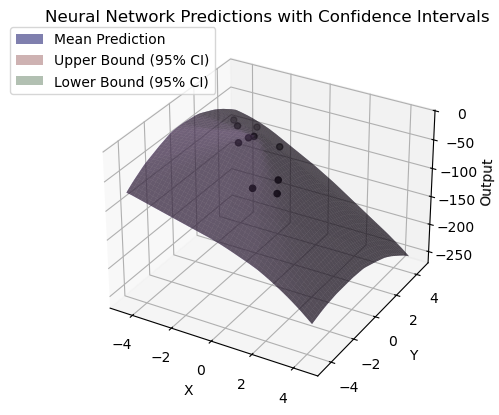

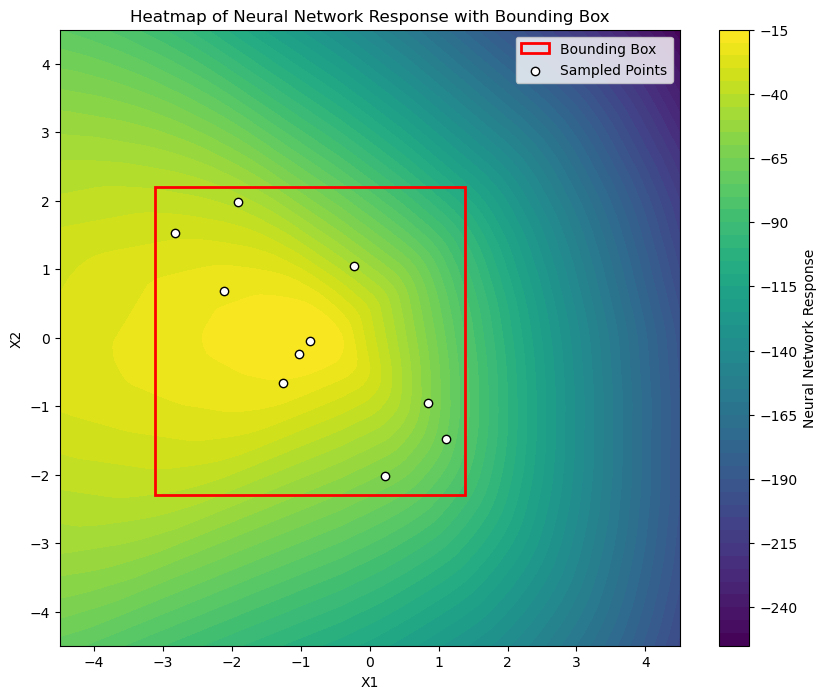

In [60]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 144
learning_rate: 0.028982296933140847
dropout_rate: 0.5
batch_size: 20
epochs: 50
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 565962.4375
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1053671.1250 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 918297.5000  
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 847843.0000 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 620175.5000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2476817.2500 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 624491.8125
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 622837.5625
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 624144.5625
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 932381.2500  
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 905907.8125  
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 874595.0625 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 

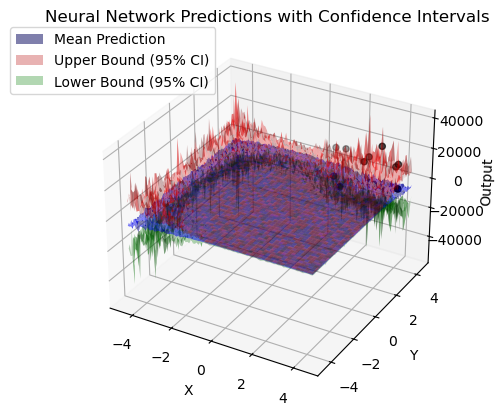

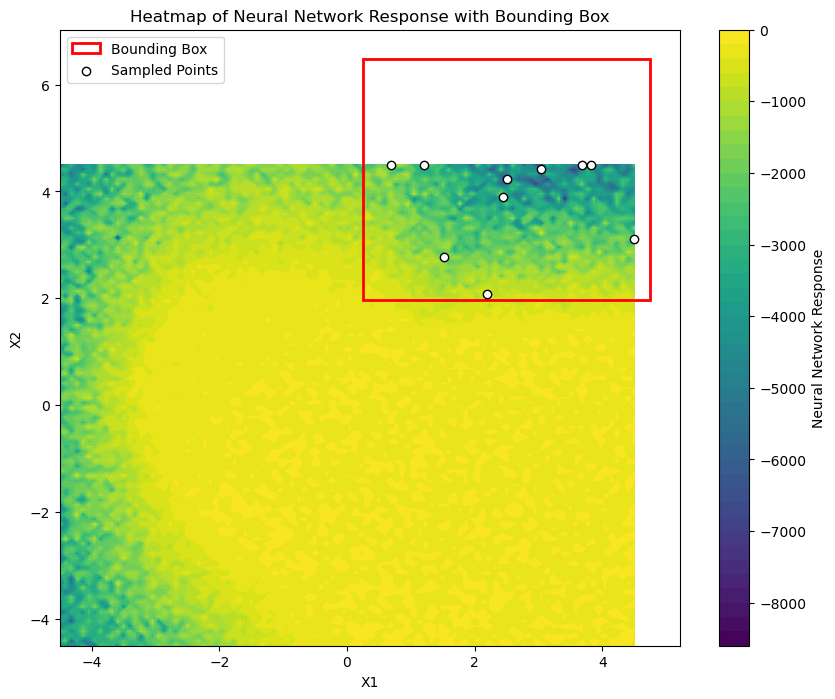

In [61]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 186
learning_rate: 0.0011524393067434675
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1068205056.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1068202624.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1068198656.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1068191744.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1068180480.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1068162816.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1068135232.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1068093120.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1068029568.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1067934656.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1067793728.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step -

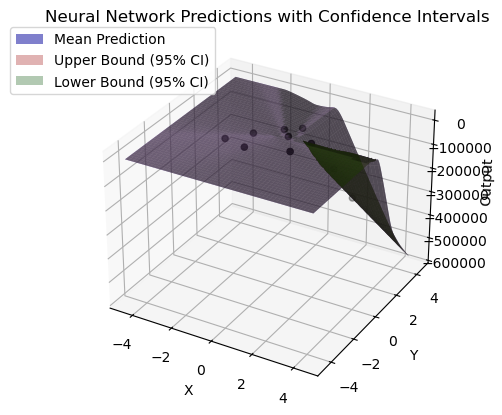

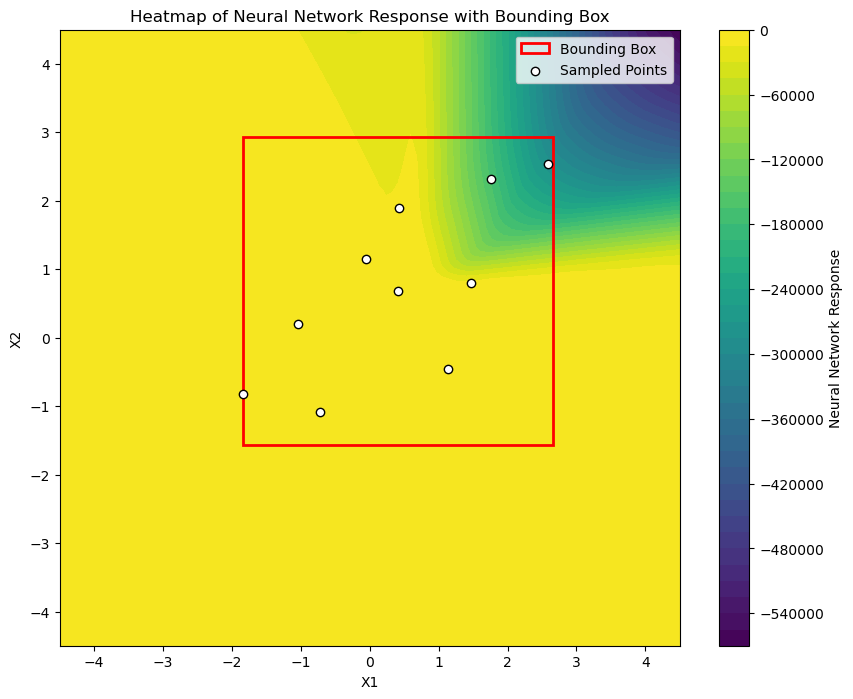

In [62]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.003202046306500194
dropout_rate: 0.0
batch_size: 150
epochs: 187
Epoch 1/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 830933888.0000
Epoch 2/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 830929152.0000
Epoch 3/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 830908736.0000
Epoch 4/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 830846464.0000
Epoch 5/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 830675712.0000
Epoch 6/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 830236096.0000
Epoch 7/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 829197248.0000
Epoch 8/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 826869184.0000
Epoch 9/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 821930560.0000
Epoch 10/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 812001984.0000
Epoch 11/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 793008064.0000
Epoch 12/187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 75849

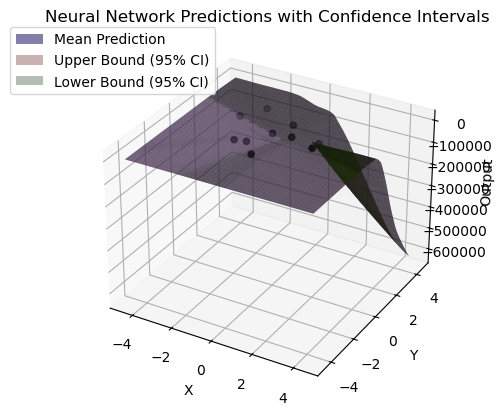

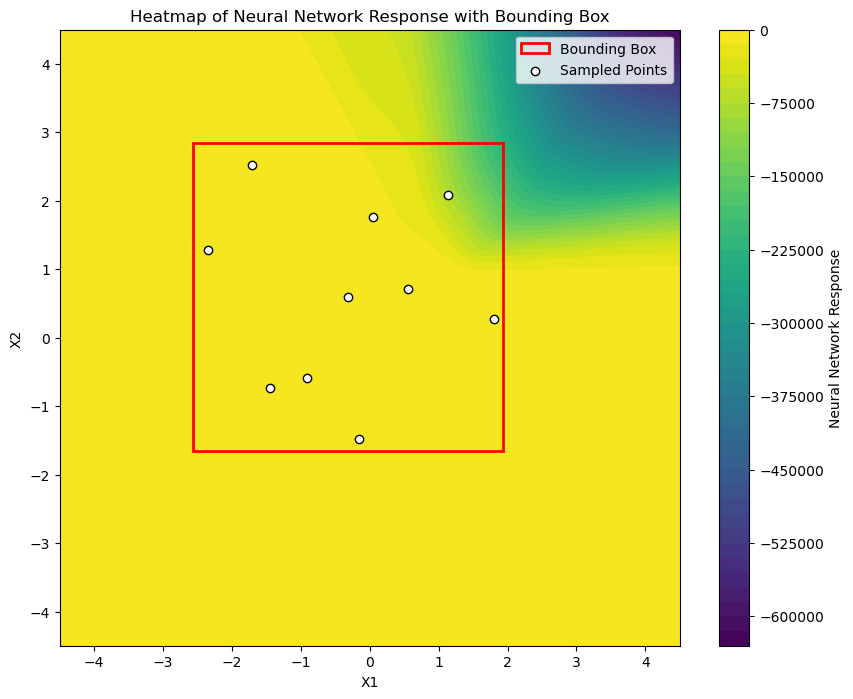

In [63]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.00028613613947406087
dropout_rate: 0.13148581973421847
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 747236672.0000
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 501135104.0000
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 634575232.0000 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 590662656.0000
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 735148672.0000 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1000139200.0000 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 431351904.0000
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 475210336.0000
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 765500480.0000 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 485076992.0000
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 643671808.0000 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

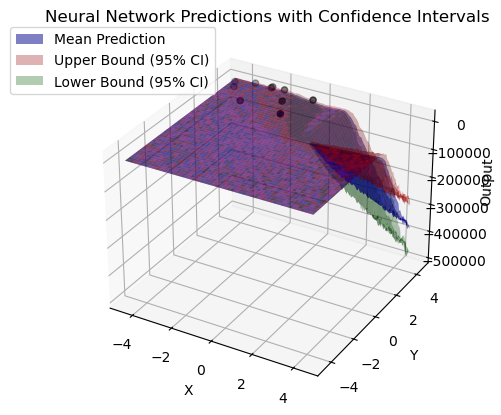

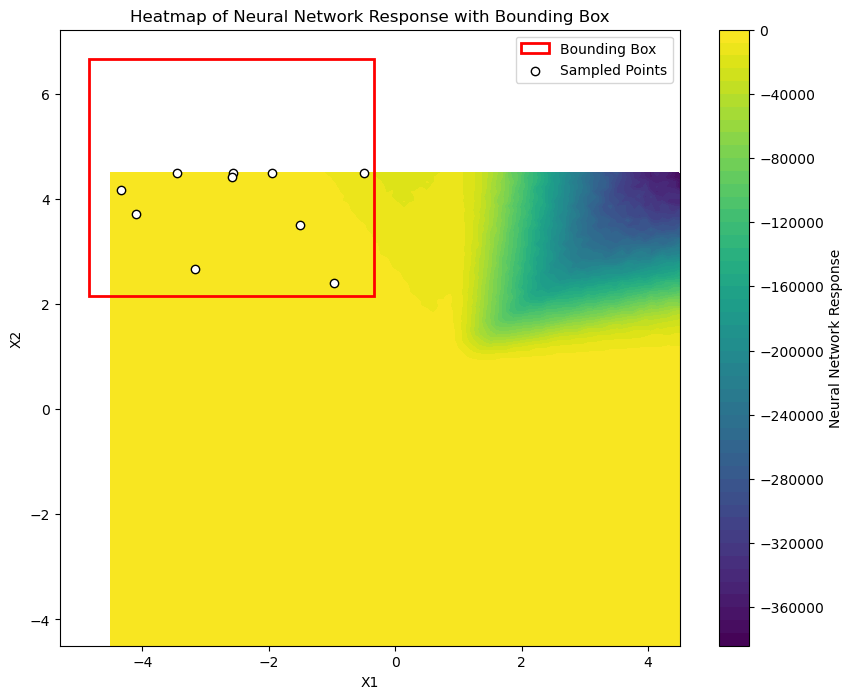

In [64]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1010289984.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1004133120.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 955932416.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 806393280.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 582112128.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 875302848.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 555520384.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 517840992.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 580942656.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 610905984.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 593489792.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 533780576.0000
Epoch

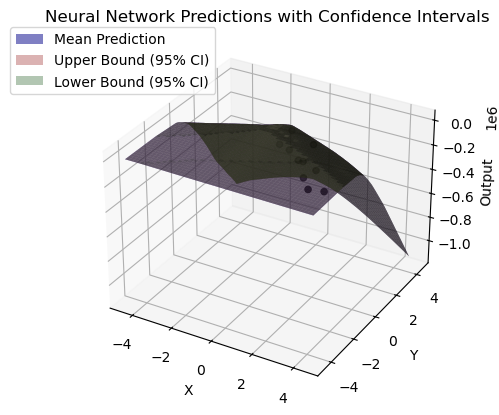

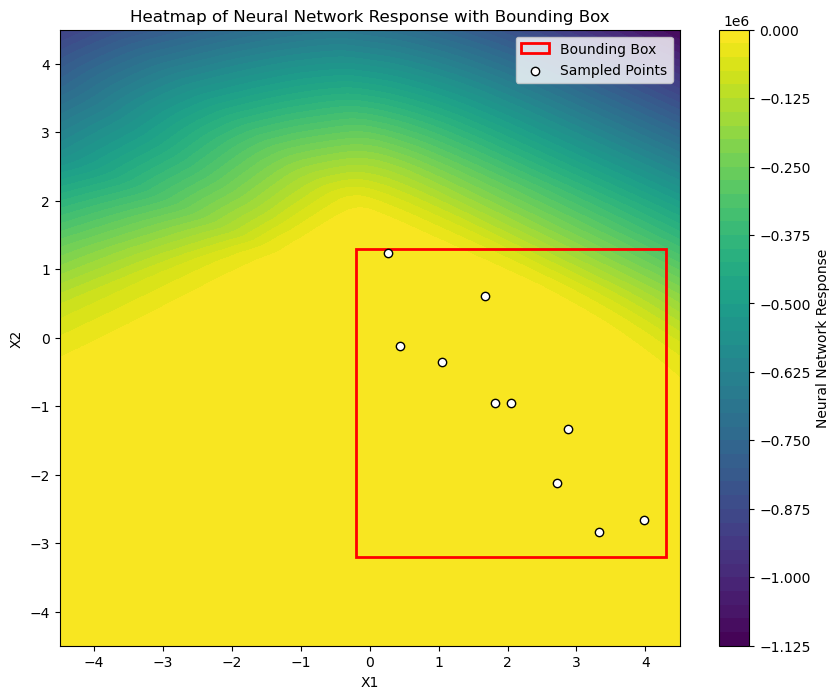

In [65]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 9
num_units: 200
learning_rate: 0.001369385732075264
dropout_rate: 0.0
batch_size: 20
epochs: 50
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 801042240.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 878430592.0000 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 956731264.0000 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 786031104.0000 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1198386816.0000 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 652826816.0000 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 625444928.0000 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 553392832.0000 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 521366592.0000 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 449815072.0000 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 423095936.0000 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 334276320.0000 
Ep

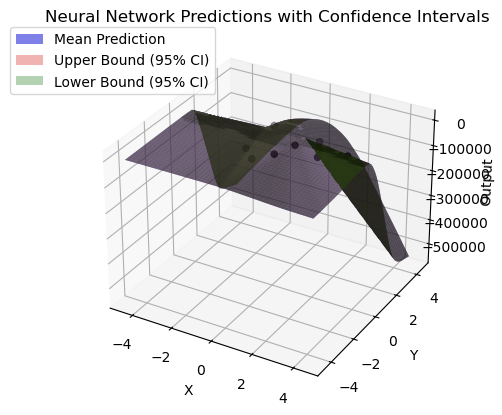

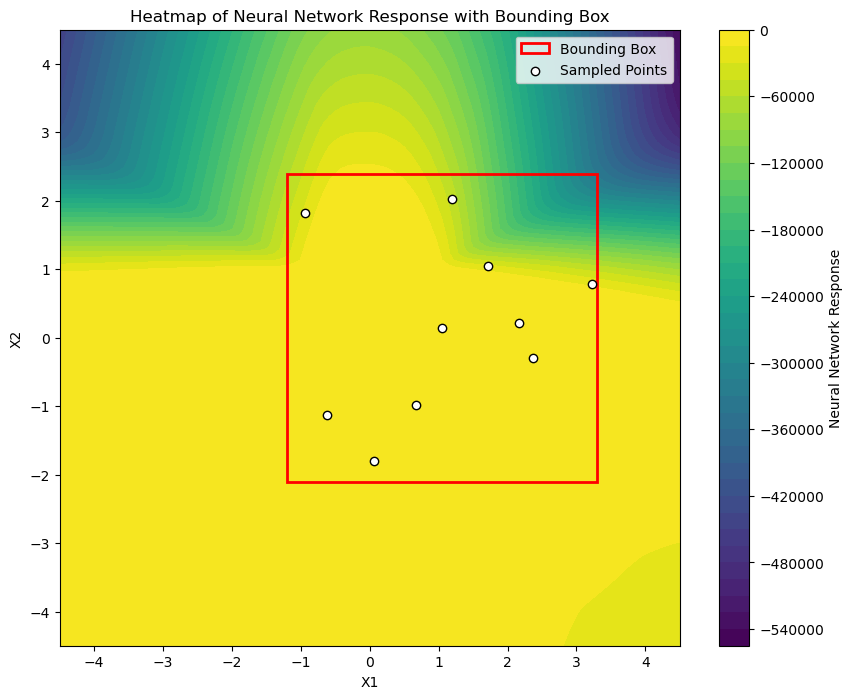

In [66]:
df_sim, df_new3 = perform_iteration(df_sim, df)

In [67]:
df

x         y            z         a         b        sim_z      diff
0   2.678123 -1.114543   -39.868271  3.904937 -3.104003   -39.985083  0.116813
1   3.229399  1.467435  -136.945332  3.904937 -3.104003  -136.808828 -0.136504
2   2.206671  3.058789 -4505.759032  3.904937 -3.104003 -4505.521850 -0.237182
3  -0.627355  0.759304   -18.043217  3.904937 -3.104003   -17.858645 -0.184571
4   1.204635 -3.110546 -1386.571330  3.904937 -3.104003 -1386.729848  0.158518
5   1.389885 -1.097293    -8.806398  3.904937 -3.104003    -8.809014  0.002616
6   1.069501  0.780979    -9.083078  3.904937 -3.104003    -9.172767  0.089689
7   0.215422  0.143510   -11.664765  3.904937 -3.104003   -11.645265 -0.019500
8  -1.093670  1.865777   -12.066610  3.904937 -3.104003   -11.941459 -0.125151
9  -0.337806  0.573122   -17.187386  3.904937 -3.104003   -17.181602 -0.005785
10 -3.828957  0.994052   -14.880965  3.904937 -3.104003   -14.782953 -0.098012
11 -0.090389 -1.282178   -16.128330  3.904937 -3.104003   -16.092656 -0.035674
12 -2.227273  0.954545   -17.114987  3.904937 -3.104003   -16.993748 -0.121240
13 -0.929434  0.299510   -26.655697  3.904937 -3.104003   -26.593605 -0.062092
14 -1.047704  0.027227   -30.685369  3.904937 -3.104003   -30.617719 -0.067651

In [68]:
df_new3

x         y         z         a         b     sim_z      diff
2  2.167555  0.212514 -0.375018  3.904937 -3.104003 -0.355087 -0.019931
4  2.367678 -0.289867 -2.471271  3.904937 -3.104003 -2.548892  0.077621
7  3.231000  0.786362 -2.652485  3.904937 -3.104003 -2.622965 -0.029520
9  1.045455  0.136364 -4.279688  3.904937 -3.104003 -4.407789  0.128101
3 -0.943380  1.815134 -4.851429  3.904937 -3.104003 -4.943982  0.092552

In [69]:
df = pd.concat([df, df_new3], ignore_index=True)

In [70]:
df

x         y            z         a         b        sim_z      diff
0   2.678123 -1.114543   -39.868271  3.904937 -3.104003   -39.985083  0.116813
1   3.229399  1.467435  -136.945332  3.904937 -3.104003  -136.808828 -0.136504
2   2.206671  3.058789 -4505.759032  3.904937 -3.104003 -4505.521850 -0.237182
3  -0.627355  0.759304   -18.043217  3.904937 -3.104003   -17.858645 -0.184571
4   1.204635 -3.110546 -1386.571330  3.904937 -3.104003 -1386.729848  0.158518
5   1.389885 -1.097293    -8.806398  3.904937 -3.104003    -8.809014  0.002616
6   1.069501  0.780979    -9.083078  3.904937 -3.104003    -9.172767  0.089689
7   0.215422  0.143510   -11.664765  3.904937 -3.104003   -11.645265 -0.019500
8  -1.093670  1.865777   -12.066610  3.904937 -3.104003   -11.941459 -0.125151
9  -0.337806  0.573122   -17.187386  3.904937 -3.104003   -17.181602 -0.005785
10 -3.828957  0.994052   -14.880965  3.904937 -3.104003   -14.782953 -0.098012
11 -0.090389 -1.282178   -16.128330  3.904937 -3.104003   -16.092656 -0.035674
12 -2.227273  0.954545   -17.114987  3.904937 -3.104003   -16.993748 -0.121240
13 -0.929434  0.299510   -26.655697  3.904937 -3.104003   -26.593605 -0.062092
14 -1.047704  0.027227   -30.685369  3.904937 -3.104003   -30.617719 -0.067651
15  2.167555  0.212514    -0.375018  3.904937 -3.104003    -0.355087 -0.019931
16  2.367678 -0.289867    -2.471271  3.904937 -3.104003    -2.548892  0.077621
17  3.231000  0.786362    -2.652485  3.904937 -3.104003    -2.622965 -0.029520
18  1.045455  0.136364    -4.279688  3.904937 -3.104003    -4.407789  0.128101
19 -0.943380  1.815134    -4.851429  3.904937 -3.104003    -4.943982  0.092552

In [71]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.85461412 -2.98975681]


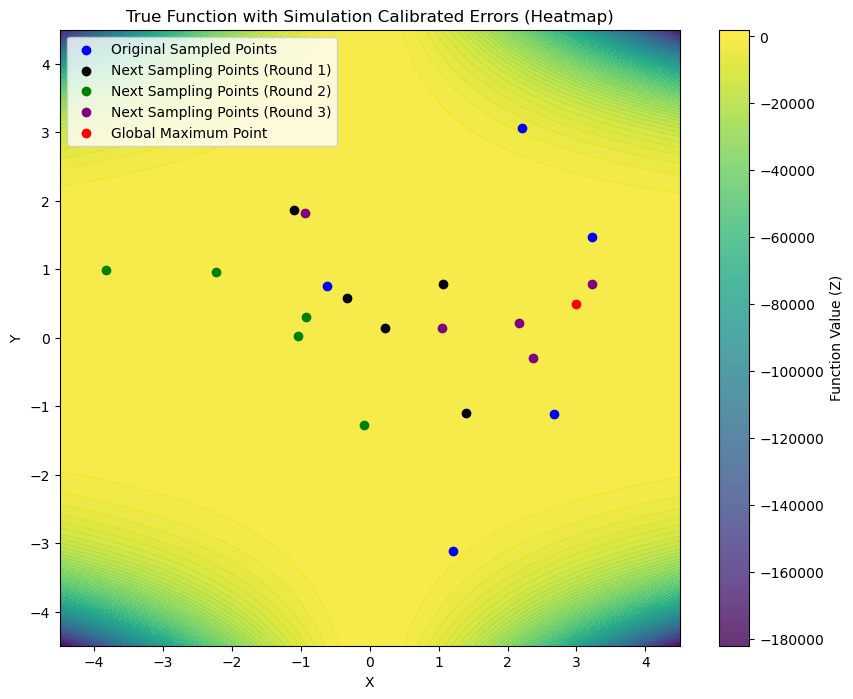

In [74]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()